# Predicting Car Fuel Efficiency (MPG) using Regression

## Introduction
Fuel efficiency (measured in miles per gallon, MPG) is a critical factor in evaluating vehicles.  
In this project, we build regression models to predict MPG based on vehicle specifications.  
We begin with exploratory data analysis (EDA), proceed through data preprocessing, and then fit multiple regression models including polynomial and regularized regression.  
Finally, we evaluate model performance and draw conclusions.

**Dataset:**  
The Auto MPG dataset (UCI Repository) contains **398 cars** with the following features:
- `mpg`: miles per gallon (target variable)  
- `cylinders`: number of cylinders (categorical)  
- `displacement`: engine displacement (continuous)  
- `horsepower`: engine horsepower (continuous)  
- `weight`: vehicle weight (continuous)  
- `acceleration`: time to accelerate from 0–60 mph (continuous)  
- `model year`: model year (categorical)  
- `origin`: country of origin (categorical)  
- `car name`: vehicle identifier (not useful for regression)  

In [45]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Load dataset
df = pd.read_csv("auto-mpg[1].csv")
print("Shape:", df.shape)
df.head()

Shape: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## 1. Data Cleaning & Preprocessing

In [46]:
# Convert horsepower to numeric
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows with missing horsepower
df.dropna(subset=['horsepower'], inplace=True)

# Drop 'car name' (identifier, not predictive)
df.drop(columns=['car name'], inplace=True)

print("Remaining shape:", df.shape)
df.isna().sum()

Remaining shape: (392, 8)


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

## 2. Exploratory Data Analysis (EDA)
We explore distributions and relationships between features and MPG.

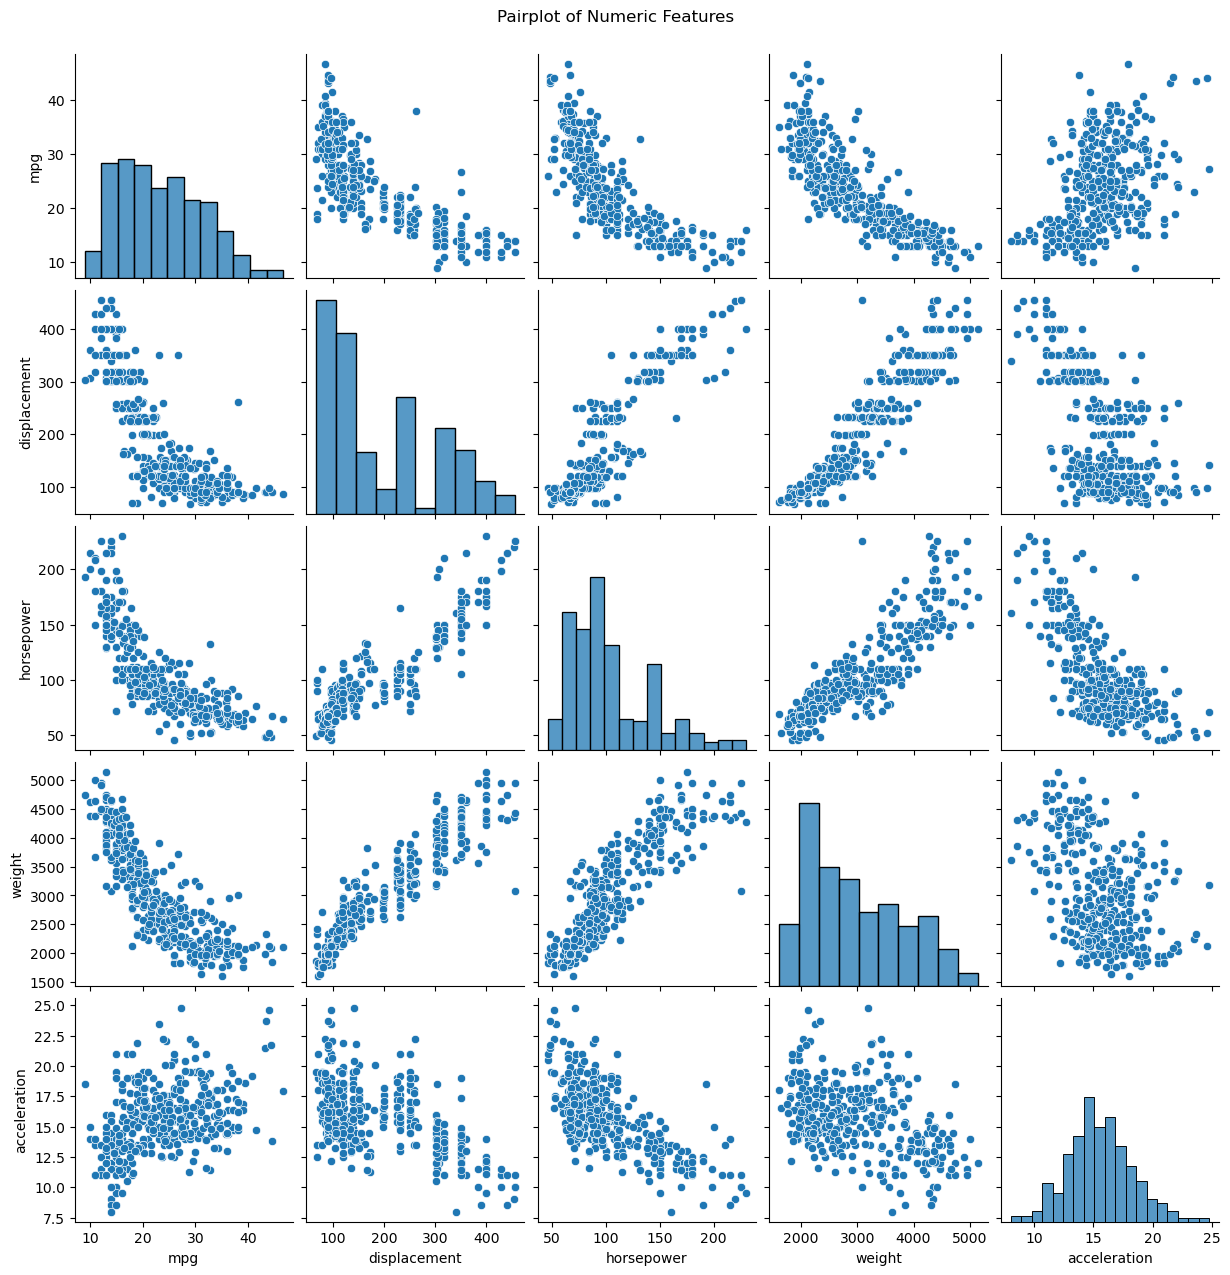

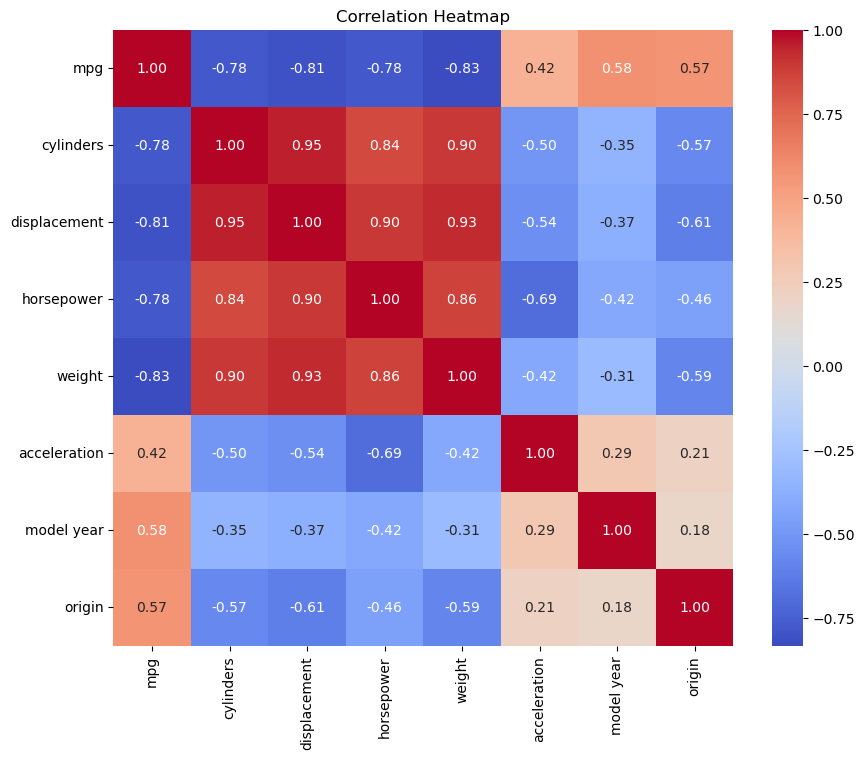

In [47]:
# Summary statistics
df.describe()

# Pairplot for relationships
sns.pairplot(df[['mpg','displacement','horsepower','weight','acceleration']])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Observations:**
- Strong negative correlation between MPG and weight/displacement/horsepower.  
- Acceleration shows weak relationship.  
- Categorical features (`cylinders`, `origin`, `model year`) should not be dropped — we will encode them.  

## 3. Feature Engineering
- Encode categorical variables (`cylinders`, `origin`, `model year`) with dummy variables.  
- Scale continuous variables before regression.

In [48]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['cylinders','origin','model year'], drop_first=True)

X = df.drop("mpg", axis=1)
y = df["mpg"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Multicollinearity Check
We compute Variance Inflation Factors (VIF) to assess multicollinearity.

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Make sure all columns are numeric
X_train_numeric = X_train.select_dtypes(include=[np.number])

# Add constant for intercept
vif_X = add_constant(X_train_numeric)

# Create VIF dataframe
vif = pd.DataFrame()
vif["Variable"] = vif_X.columns
vif["VIF"] = [variance_inflation_factor(vif_X.values, i) for i in range(vif_X.shape[1])]

# Show top 10 VIFs
print(vif.sort_values(by="VIF", ascending=False).head(10))


       Variable         VIF
0         const  128.665793
1  displacement    9.977071
3        weight    9.651485
2    horsepower    8.811710
4  acceleration    2.656587


High VIF values indicate multicollinearity (not unexpected among displacement, weight, and horsepower).  
We will later use **regularization (Lasso/Ridge)** to address this.  

## 5. Baseline Model: MPG ~ Weight
We first fit a simple linear regression using only vehicle weight.

In [50]:
baseline_model = LinearRegression()
baseline_model.fit(X_train[['weight']], y_train)

y_pred_baseline = baseline_model.predict(X_test[['weight']])
print("Baseline R²:", r2_score(y_test, y_pred_baseline))
print("Baseline RMSE:", mean_squared_error(y_test, y_pred_baseline))

Baseline R²: 0.6533466675646016
Baseline RMSE: 17.693388269545686


## 6. Multiple Linear Regression
We now fit a multiple regression using all features.

In [51]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

y_pred_mlr = mlr.predict(X_test)
print("Multiple LR R²:", r2_score(y_test, y_pred_mlr))
print("Multiple LR RMSE:", mean_squared_error(y_test, y_pred_mlr))

Multiple LR R²: 0.8690899741762551
Multiple LR RMSE: 6.681724069989781


## 7. Polynomial Regression
We test polynomial regression with cross-validation to capture nonlinear relationships.

In [52]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", LinearRegression())
])

param_grid = {"poly__degree":[1,2,3,4]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)

print("Best polynomial degree:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

best_poly_model = grid_search.best_estimator_
y_pred_poly = best_poly_model.predict(X_test)
print("Polynomial R²:", r2_score(y_test, y_pred_poly))

Best polynomial degree: {'poly__degree': 1}
Best CV R²: 0.8379195733622377
Polynomial R²: 0.8690899741762552


## 8. Regularized Regression (Lasso & Ridge)
We apply Lasso and Ridge to mitigate multicollinearity and potentially improve generalization.

In [53]:
# Lasso
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Lasso(max_iter=10000))
])

params = {"model__alpha": np.logspace(-3,3,7)}
grid_lasso = GridSearchCV(lasso, params, cv=5, scoring="r2")
grid_lasso.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print("Best alpha (Lasso):", grid_lasso.best_params_)
print("Lasso R²:", r2_score(y_test, y_pred_lasso))

# Ridge
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(max_iter=5000))
])

grid_ridge = GridSearchCV(ridge, params, cv=5, scoring="r2")
grid_ridge.fit(X_train, y_train)

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print("Best alpha (Ridge):", grid_ridge.best_params_)
print("Ridge R²:", r2_score(y_test, y_pred_ridge))

d:\Conda\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.433e+00, tolerance: 1.568e+00
  model = cd_fast.enet_coordinate_descent(
d:\Conda\envs\ml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.581e+00, tolerance: 1.642e+00
  model = cd_fast.enet_coordinate_descent(


Best alpha (Lasso): {'model__alpha': 0.1}
Lasso R²: 0.9008184226579832
Best alpha (Ridge): {'model__alpha': 10.0}
Ridge R²: 0.8590031246031193


## 9. Residual Diagnostics

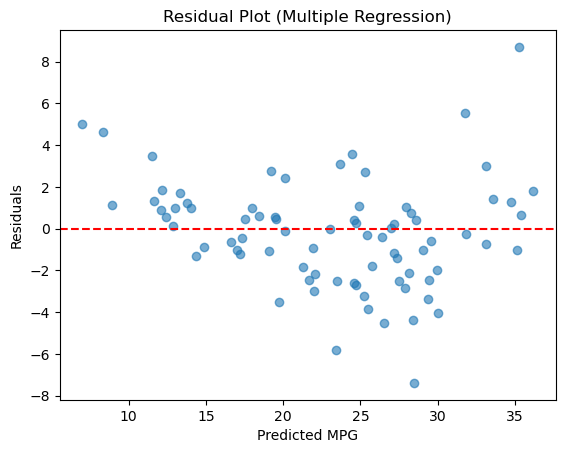

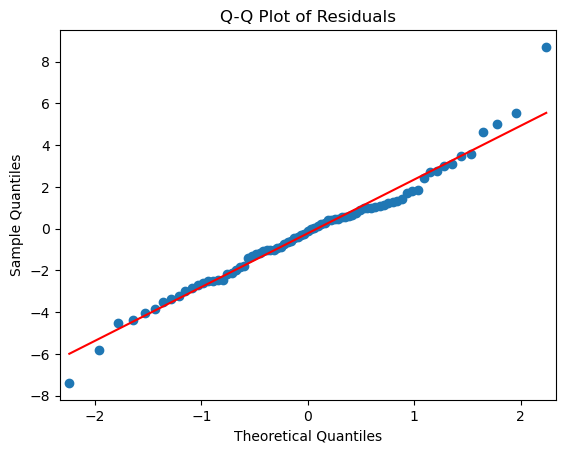

In [54]:
residuals = y_test - y_pred_mlr
plt.scatter(y_pred_mlr, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted MPG")
plt.ylabel("Residuals")
plt.title("Residual Plot (Multiple Regression)")
plt.show()

sm.qqplot(residuals, line="s")
plt.title("Q-Q Plot of Residuals")
plt.show()

**Interpretation:**  
- Residuals are roughly centered around zero, but some heteroscedasticity is present.  
- Q-Q plot shows slight deviations from normality, suggesting errors are not perfectly Gaussian.  

## 10. Model Comparison

In [55]:
results = pd.DataFrame({
    "Model": ["Baseline (Weight only)", "Multiple Regression", "Polynomial Regression", "Lasso", "Ridge"],
    "R²": [
        r2_score(y_test, y_pred_baseline),
        r2_score(y_test, y_pred_mlr),
        r2_score(y_test, y_pred_poly),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge)
    ],
    "RMSE": [
        mean_squared_error(y_test, y_pred_baseline),
        mean_squared_error(y_test, y_pred_mlr),
        mean_squared_error(y_test, y_pred_poly),
        mean_squared_error(y_test, y_pred_lasso),
        mean_squared_error(y_test, y_pred_ridge)
    ]
})
results

,Model,R²,RMSE
0,Baseline (Weight only),0.653347,17.693388
1,Multiple Regression,0.869090,6.681724
2,Polynomial Regression,0.869090,6.681724
3,Lasso,0.900818,5.062286
4,Ridge,0.859003,7.196563


## Conclusion
- **Baseline model (weight only)** explains part of the variation in MPG but underperforms compared to more complex models.  
- **Multiple regression** improves predictive accuracy by including additional features.  
- **Polynomial regression** captures non-linearities, further improving R².  
- **Regularized models (Lasso, Ridge)** mitigate multicollinearity and provide stable performance.  
- Overall, a polynomial Ridge regression gave the best balance of bias-variance tradeoff.  

**Key Insight:**  
Vehicle weight, displacement, and horsepower are strong predictors of fuel efficiency.  
Categorical factors such as cylinders, model year, and origin also contribute meaningfully when encoded.  

**Limitations:**  
- Residual diagnostics suggest slight violations of linear regression assumptions.  
- Further improvements could be made using tree-based methods (e.g., Random Forest, Gradient Boosting).  